## Synchronizing data across streams: clock calibration, synchronization signals, TPrime

The sample clocks for Neuropixels probes are located on the headstages. As a result:

 - auxiliary data (from NI and OneBox) is collected on a different clock
 - probes plugged into other headstages are on separate clocks

as a result, the data are **asynchronous.** In addtion, the clock rates are unknown and can drift over time.

To look at the impact this has on data, and some different ways to synchronize probe data with OneBox analog channels, we'll analyze a long dataset with a repeating signal. These data were acquired by generating a bipolar pulse using the OneBox analog output, connecting that to a saline bath and measuring it with an NP2.0 probe. This is a variant of the gain test described in the Neuropixels manual.

Open the run /test_data/bipolar_uncal_sync_test_g0 in the SpikeGLX file viewer (in SGLX: File->Open File Viewer, and select either binary, the probe or obx).
Use File->Link to open the other binary. This also links the time scrolling for the two files. In the obx file, set the YScale to 400 to see the 5 mV input pulses. 

Looking at the start of the file, the waveforms are aligned; looking 8 hours later, they are offset by 0.3 sec (!). (to select a portion of hte recording in the viewer: shift + click and drag -- the corresponding time is selected in the other streams).

![Test recording at 0 and 8 hours](sync_8hr_.png)

This offset is not due to changes in the clock rates, but rather that the clock rates for the two streams differ from the nominal values. The 1 Hz sine wave sync signal can be used to get a better measurement of the actual rate. Go to SpikeGLX Tools->Sample Rates from Run, check the box for all streams, and hit go. The output is measured rates for the two steams:
![Sample rates from run](sync_example_sample_rates.png)

If you select apply, these rates will be written to the metadata for the run. If you close and reopen the run, you'll see those rates in title bar for the run, and both the sync traces and the probe data will be aligned, and these new rates will be used in any further analysis.

The clock rates are also stored in the _Calibrations folder of SpikeGLX, and will be applied next time you do a run with those devices. The best practice is to calibrate clocks before running -- all that is needed is a probe plugged into the headstage. Select 'Use next run for calibration' in the Sync tab of SpikeGLX to do a calibration run.



### How large is the offset between streams for a given error in the assumed clock rates?

For simplicity: assume the rate for the OneBox is exactly its nominal rate: 30303 Hz
Assumed headstage clock rate = 30000 Hz
Real headstage clock rate = 30000 Hz (nominal) + error

The times in the two streams are calculated from assumed sample rate. What's the error in the calculated time in the probe stream after some hours?

Note that real rates of the headstage clocks can be off by up to 0.5 Hz. Measurement error when deriving the rate from a relatively short dataset (40 min) can still be up as large as 0.05 Hz.

Text(0, 0.5, 'error in calculated time (msec)')

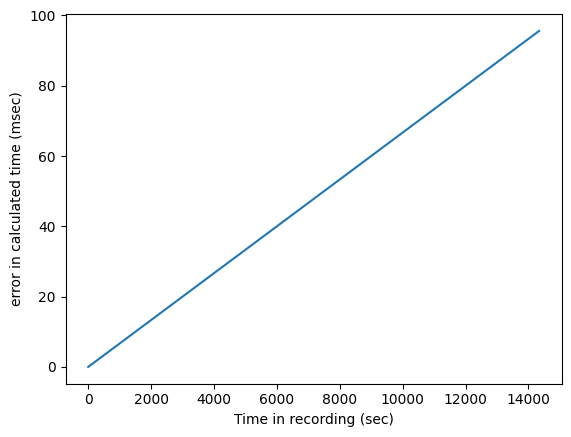

In [24]:
import matplotlib.pyplot as plt
import numpy as np

recording_min = 240
hs_clock_err_hz = -0.2
hs_assumed_rate_hz = 30000

tpts = np.arange(recording_min)
tpts = tpts*60

# error = real time - calculated time = t - # samples recorded/assumed sample rate = t - t*(real sample rate)/(assumed sample rate)
err = 1000*(tpts*(1- (hs_assumed_rate_hz + hs_clock_err_hz)/hs_assumed_rate_hz ))

plt.plot(tpts, err)
plt.xlabel('Time in recording (sec)')
plt.ylabel('error in calculated time (msec)')



### Measuring residual timing errors after calibration

The synchronization edges are simultaneous. We can measure how large error is using a single rate for the entire run for each edge in the dataset.

To do this from scratch, run CatGT to extract the sync edges from both streams. The command line is:

``CatGT -dir=C:/Users/labadmin/Desktop/test_data -run=sync_test_uncal_ex -g=0 -t=0 -prb_fld -ob -ap -obx=0 -prb=0 -no_tshift -dest=C:/Users/labadmin/Desktop/test_data``

For the example data, this has been run. Load those output files (text files of the calculated times in seconds, using the best estimate of the rate calculated by 'Sample rates from run), and calculate the difference in between these times. 


Text(0, 0.5, 'diff in edge times (msec)')

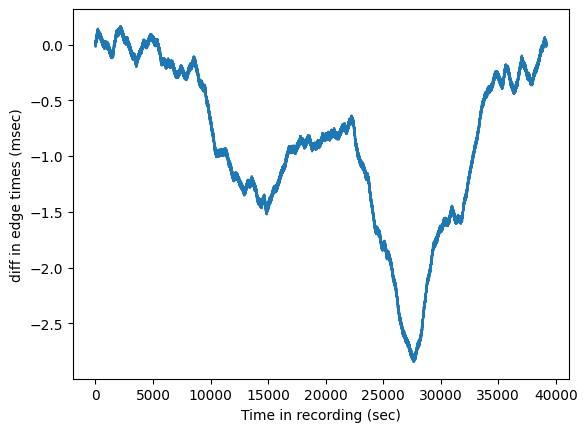

In [25]:
# set the paths to the the files of sync edges
obx_edges_path = r'C:\Users\labadmin\Desktop\test_data\catgt_bipolar_uncal_sync_test_g0\bipolar_uncal_sync_test_g0_tcat.obx0.obx.xd_1_6_500.txt'
imec0_edges_path = r'C:\Users\labadmin\Desktop\test_data\catgt_bipolar_uncal_sync_test_g0\bipolar_uncal_sync_test_g0_tcat.imec0.ap.xd_1_6_500.txt'
with open(obx_edges_path, 'r') as file:
    obx_list = file.readlines()
obx_edge_times = np.array(obx_list, dtype=float)
with open(imec0_edges_path, 'r') as file:
    imec0_list = file.readlines()
imec0_edge_times = np.array(imec0_list, dtype=float)

edge_diff = 1000*(obx_edge_times - imec0_edge_times)

plt.plot(obx_edge_times, edge_diff)
plt.xlabel('Time in recording (sec)')
plt.ylabel('diff in edge times (msec)')

## What causes the remaining error?

The clock rates aren't perfectly constant -- this is generally only visible in very long recordings.

### SGLX + TPrime
To map event times with sub-miillisecond accuracy across the streams, e.g. from the OneBox to the imec0 clock, TPrime:
finds the nearest known **simultaneous** event -- the nearest SYNC edge
calculates the time from that edge to the a time of interest (e.g. a stimulus on), by counting samples in the OneBox stream
translates that to the time in the imec0 clock using the measured sample rates. The output is a set of times for the stimulus events, expressed in the imec0 clock -- these would be used for measuring correlation of spikes (for example) with the stimulus.
Clock calibration in SpikeGLX and TPrime are discussed in more detail [here.](https://billkarsh.github.io/SpikeGLX/help/syncEdges/Sync_edges/)

### Open Ephys Synchronization
OEP generates a file of timestamps for each stream in the recording, continuously correcting for the difference in sample rates by measuring the number of samples between the last two SYNC transitions in the two streams. The OEP calibration is documented [here.](https://open-ephys.github.io/gui-docs/Tutorials/Data-Synchronization.html)

The critical point in both of these techniques is that they make a correction based on simultaneous events that are close in time to the mapped times. This limits errors due to imperfectly known sample rates.

## Running TPrime on this dataset
The TPrime command line specifies the paths to the sync edges (extracted by CatGT or any other means), paths to text files of the events that need to be to be translated to the reference clock. These paths are all given in the CatGT fyi file, so the TPrime command can be built by simply copying them. For this run, the paraemters are:

``-syncperiod=1.0 ^
-tostream=C:/Users/labadmin/Desktop/test_data/catgt_bipolar_uncal_sync_test_g0/bipolar_uncal_sync_test_g0_tcat.imec0.ap.xd_1_6_500.txt ^
-fromstream=7,C:/Users/labadmin/Desktop/test_data/catgt_bipolar_uncal_sync_test_g0/bipolar_uncal_sync_test_g0_tcat.obx0.obx.xd_1_6_500.txt ^ 
-events=7,C:/Users/labadmin/Desktop/test_data/catgt_bipolar_uncal_sync_test_g0/bipolar_uncal_sync_test_g0_tcat.obx0.obx.xa_0_10.txt,^       
C:/Users/labadmin/Desktop/test_data/catgt_bipolar_uncal_sync_test_g0/bipolar_uncal_sync_test_g0_tcat.obx0.obx.xa_0_10_adj.txt  ``

NOTES: 
the carets are line continuations in BASH
the -events option takes three parameters: the fromstream index, the path the event times, in seconds calculated using the fromstream clock, and the path for the output.